In [9]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [439]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langgraph.graph.message import add_messages
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver

from pydantic import BaseModel, Field, ValidationError
from typing import Annotated, Literal
import json
import re

class CustomBaseModel(BaseModel):
    @classmethod
    def get_json_schema(cls) -> str: 
        return json.dumps(cls.model_json_schema()["properties"])


class Goal(CustomBaseModel):
    name: str = Field("Name of the goal that user is trying to achieve")
    amount: float = Field("Amount that user is trying to save for the given goal")

class UserProfile(CustomBaseModel):
    income: float = Field(description="monthly income")
    expenses: float = Field(description="monthly expenses")
    tolerance: Literal["low", "medium", "high"] = Field(description="Risk tolerance")
    preferences: list[str] = Field(default=[], description="A list of user's preferences where they'd like to invest.")
    goals: list[Goal] = Field(default=[], description="A list of goals that user is trying to achieve by investing")
    

In [440]:
def extract_content_from_tags(tag_name, txt: str):
    match = re.search(f"<{tag_name}>(.*?)</{tag_name}>", txt, re.DOTALL)
    return match[1] if match else None

In [465]:
class SharedState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages] = Field(default=[])
    user_profile: UserProfile = Field(default=None, description="contains information regarding User's income/expenses/their risk tolerance etc.")
    question_to_ask: str | None = Field(default=None)
    user_response: str | None = Field(default=None)

In [466]:
def collect_user_profile(state: SharedState):
    prompt_template = """
    You are a financial assistant. Your task is to extract a user's financial profile from their message, strictlyt following the provided JSON schema.

    Instructions:
    1. Use the JSON schema provided in <schema></schema> as an example to determine which fields to extract, their types, and any default values.
    2. If a field is missing in the user's input but has a default in the schema use that default.
        - If the field is mandatory and missing, Generate a short descriptive question and (if mthere are multiple questions to ask, unify and ask as single) and enclose it within <question_to_ask></question_to_ask>

    3. only include fields defined in the schema.
    4. output valid JSON
    5. Do not add any extra fields
    6. Do not make any assumptions. Strictly follow the guidelines

    <schema>
    %s
    </schema>

    This is the input example:
    "I earn 5000$ per month and I spend 3000$. I want to save 2000$ for a vacation."

    Example of expected JSON output(wrap the JSON within <generated_json></generated_json> tags):
    {
        "income": 5000,
        "expenses": 3000,
        "tolerance": "medium",
        "preferences": [],
        "goals: [{"name": "vacation", "amount": 2000}]
    }
    """
    system_message = SystemMessage(prompt_template % UserProfile.get_json_schema())
    
    try:
        llm_response = llm.invoke([system_message] + state.messages)
        extracted_content = extract_content_from_tags("question_to_ask", llm_response.content)
        if extracted_content is not None:
            state.messages = [] + [llm_response]
            state.question_to_ask = extracted_content
            return state

        extracted_content = extract_content_from_tags("generated_json", llm_response.content)
        extracted_json = json.loads(extracted_content)
        user_profile = UserProfile(**extracted_json)
        
    except ValidationError as e:
        print("validation error!")
        user_profile = None
        
    state.question_to_ask = None
    state.user_response = None
    state.messages = [llm_response]
    state.user_profile = user_profile
    return state

def should_ask_to_clarify(state: SharedState) -> Literal["ask_user_to_clarify", END]:
    user_profile = state.user_profile
    
    if user_profile is None or user_profile.income == 0 or user_profile.expenses == 0:
        return "ask_user_to_clarify"
    
    return END
    
def ask_user_to_clarify(state: SharedState) -> Command[Literal["collect_user_profile"]]:
    user_response = interrupt(f"\n {state.question_to_ask}")
    print("I am updating")
    return Command(goto="collect_user_profile", update={"messages": [AIMessage(state.question_to_ask), HumanMessage(user_response)]})
    
    
    
    
    

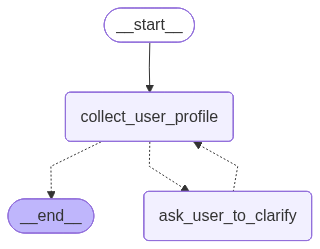

In [467]:
builder = StateGraph(SharedState)
builder.add_node(collect_user_profile)
builder.add_node(ask_user_to_clarify)

builder.set_entry_point("collect_user_profile")
builder.add_conditional_edges("collect_user_profile", should_ask_to_clarify)

graph = builder.compile(checkpointer=InMemorySaver())
graph

In [468]:
config = {"configurable": {"thread_id": 1}}
state = SharedState(messages=[HumanMessage("I make around 3k a month. I spend 2k a month")])

In [469]:
graph.invoke(state, config)

{'messages': [HumanMessage(content='I make around 3k a month. I spend 2k a month', additional_kwargs={}, response_metadata={}, id='a7fb6c61-a309-421d-88a1-aed60c48acc5'),
  AIMessage(content='To generate the user\'s financial profile, I will extract the relevant information from the input message. \n\nFrom the input, I can see that the user\'s monthly income is $3000 and their monthly expenses are $2000. However, the input is missing some fields that are defined in the schema, such as "trial", "tolerance", "preferences", and "goals". \n\nSince "trial" and "tolerance" are not provided, and they do not have default values, I will ask for this information. \n"tolerance" has an enum, so I will provide options for this.\n"trial" is a boolean, so I will provide options for this as well.\n\nHere is the question to ask: \n<question_to_ask>What is your risk tolerance (low, medium, high) and are you interested in a trial (yes or no)?</question_to_ask>\n\nHowever, since "preferences" and "goals" 

In [472]:
interrupts = graph.get_state(config).interrupts

if interrupts:
    user_response = input(interrupts[0].value)
    graph.invoke(Command(resume=user_response), config)

In [473]:
for m in graph.get_state(config).values["messages"]:
    m.pretty_print()
    

================================ Human Message =================================

I make around 3k a month. I spend 2k a month
================================== Ai Message ==================================

To generate the user's financial profile, I will extract the relevant information from the input message. 

From the input, I can see that the user's monthly income is $3000 and their monthly expenses are $2000. However, the input is missing some fields that are defined in the schema, such as "trial", "tolerance", "preferences", and "goals". 

Since "trial" and "tolerance" are not provided, and they do not have default values, I will ask for this information. 
"tolerance" has an enum, so I will provide options for this.
"trial" is a boolean, so I will provide options for this as well.

Here is the question to ask: 
<question_to_ask>What is your risk tolerance (low, medium, high) and are you interested in a trial (yes or no)?</question_to_ask>

However, since "preferences" and "goa